In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
from gensim.models import word2vec
import talos as ta
from keras.layers import Dropout
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
%matplotlib inline

In [5]:
df = pd.read_csv('base_elon_data.csv')

df.head()

,Unnamed: 0,ID,Date,Tweet,Retweets,Tweet Length,Sentiment,Polarity
0,0,0,2010-06-05,Please ignore prior tweets as that was someone...,"5,453",106,0,0.00
1,1,1,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,188,129,1,0.65
2,2,2,2011-12-01,I made the volume on the Model S,78,125,0,0.00
3,3,3,2011-12-03,Great Voltaire quote arguably better than Twai...,44,145,1,0.45
4,4,4,2011-12-03,That was a total non sequitur btw,50,42,0,0.00


In [10]:
df_pca = pd.read_csv('updated_target_merged_pca_data.csv')

In [13]:
df_pca.head()

,Unnamed: 0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_6542,pc_6543,pc_6544,pc_6545,pc_6546,pc_6547,pc_6548,pc_6549,pc_6550,pc_6551
0,0,-0.105592,-0.029830,-0.083962,0.082105,0.017019,0.134082,-0.072522,-0.006849,-0.068842,...,-4.571805e-16,9.392261e-17,-5.865131e-17,1.153722e-17,-1.133192e-17,6.973199e-19,1.421004e-18,7.973121e-18,2.735286e-17,2.367685e-17
1,1,-0.099076,-0.021082,-0.038139,0.000626,0.003329,-0.062547,0.042404,0.019719,0.089294,...,-2.105499e-16,-5.449746e-17,-8.136704e-17,-1.317968e-16,9.153250e-19,3.419070e-17,5.365583e-17,9.245788e-17,3.291252e-19,2.017045e-16
2,2,-0.114546,-0.035896,-0.126653,0.046923,0.045059,-0.215881,0.223829,-0.022574,-0.048085,...,-3.342434e-17,-2.531083e-17,1.944576e-18,-7.136464e-18,-2.730728e-18,-8.282076e-18,-3.119485e-17,3.070494e-18,2.124110e-17,-7.346423e-19
3,3,-0.091030,-0.017803,0.093363,0.155490,0.025837,-0.022723,0.038680,-0.032345,-0.094818,...,-1.920605e-17,-5.913349e-18,-8.806813e-18,4.862371e-17,9.517792e-18,3.120914e-17,1.510482e-17,-1.147137e-17,-4.133473e-17,2.643325e-18
4,4,-0.083948,-0.008909,0.008896,0.003783,0.006889,0.062488,-0.047705,-0.032693,-0.075397,...,3.599001e-17,-1.763078e-17,2.637216e-17,2.949157e-18,3.860744e-17,1.692308e-17,-1.302176e-17,3.904398e-17,-2.249672e-17,-4.268464e-18


In [6]:
stock = pd.read_csv('TSLA_addStockComp.csv')

In [7]:
stock.head()

,Date,Open,Close,Volume,gap,upDown
0,2010-06-29,3.800,4.778,93831500,25.73,1
1,2010-06-30,5.158,4.766,85935500,-7.59,-1
2,2010-07-01,5.000,4.392,41094000,-12.15,-1
3,2010-07-02,4.600,3.840,25699000,-16.52,-1
4,2010-07-06,4.000,3.222,34334500,-19.45,-1


In [8]:
df_1 = df[['ID', 'Date', 'Tweet', 'Retweets', 'Tweet Length', 'Sentiment', 'Polarity']]

In [14]:
df_2 = pd.concat([df_1, df_pca], axis=1)

In [15]:
df_up = stock[['upDown']]

In [16]:
df_3 = pd.concat([df_2, df_up], axis=1)

In [17]:
df_3.head()

,ID,Date,Tweet,Retweets,Tweet Length,Sentiment,Polarity,Unnamed: 0,pc_1,pc_2,...,pc_6543,pc_6544,pc_6545,pc_6546,pc_6547,pc_6548,pc_6549,pc_6550,pc_6551,upDown
0,0,2010-06-05,Please ignore prior tweets as that was someone...,"5,453",106,0,0.00,0.0,-0.105592,-0.029830,...,9.392261e-17,-5.865131e-17,1.153722e-17,-1.133192e-17,6.973199e-19,1.421004e-18,7.973121e-18,2.735286e-17,2.367685e-17,1.0
1,1,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,188,129,1,0.65,1.0,-0.099076,-0.021082,...,-5.449746e-17,-8.136704e-17,-1.317968e-16,9.153250e-19,3.419070e-17,5.365583e-17,9.245788e-17,3.291252e-19,2.017045e-16,-1.0
2,2,2011-12-01,I made the volume on the Model S,78,125,0,0.00,2.0,-0.114546,-0.035896,...,-2.531083e-17,1.944576e-18,-7.136464e-18,-2.730728e-18,-8.282076e-18,-3.119485e-17,3.070494e-18,2.124110e-17,-7.346423e-19,-1.0
3,3,2011-12-03,Great Voltaire quote arguably better than Twai...,44,145,1,0.45,3.0,-0.091030,-0.017803,...,-5.913349e-18,-8.806813e-18,4.862371e-17,9.517792e-18,3.120914e-17,1.510482e-17,-1.147137e-17,-4.133473e-17,2.643325e-18,-1.0
4,4,2011-12-03,That was a total non sequitur btw,50,42,0,0.00,4.0,-0.083948,-0.008909,...,-1.763078e-17,2.637216e-17,2.949157e-18,3.860744e-17,1.692308e-17,-1.302176e-17,3.904398e-17,-2.249672e-17,-4.268464e-18,-1.0


In [18]:
df_2 = df_3.drop(columns=['Unnamed: 0'])

In [20]:
scaler = StandardScaler()

In [21]:
df_2.head()

,ID,Date,Tweet,Retweets,Tweet Length,Sentiment,Polarity,pc_1,pc_2,pc_3,...,pc_6543,pc_6544,pc_6545,pc_6546,pc_6547,pc_6548,pc_6549,pc_6550,pc_6551,upDown
0,0,2010-06-05,Please ignore prior tweets as that was someone...,"5,453",106,0,0.00,-0.105592,-0.029830,-0.083962,...,9.392261e-17,-5.865131e-17,1.153722e-17,-1.133192e-17,6.973199e-19,1.421004e-18,7.973121e-18,2.735286e-17,2.367685e-17,1.0
1,1,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,188,129,1,0.65,-0.099076,-0.021082,-0.038139,...,-5.449746e-17,-8.136704e-17,-1.317968e-16,9.153250e-19,3.419070e-17,5.365583e-17,9.245788e-17,3.291252e-19,2.017045e-16,-1.0
2,2,2011-12-01,I made the volume on the Model S,78,125,0,0.00,-0.114546,-0.035896,-0.126653,...,-2.531083e-17,1.944576e-18,-7.136464e-18,-2.730728e-18,-8.282076e-18,-3.119485e-17,3.070494e-18,2.124110e-17,-7.346423e-19,-1.0
3,3,2011-12-03,Great Voltaire quote arguably better than Twai...,44,145,1,0.45,-0.091030,-0.017803,0.093363,...,-5.913349e-18,-8.806813e-18,4.862371e-17,9.517792e-18,3.120914e-17,1.510482e-17,-1.147137e-17,-4.133473e-17,2.643325e-18,-1.0
4,4,2011-12-03,That was a total non sequitur btw,50,42,0,0.00,-0.083948,-0.008909,0.008896,...,-1.763078e-17,2.637216e-17,2.949157e-18,3.860744e-17,1.692308e-17,-1.302176e-17,3.904398e-17,-2.249672e-17,-4.268464e-18,-1.0


In [24]:
target = df_2.upDown

<AxesSubplot:xlabel='upDown', ylabel='count'>

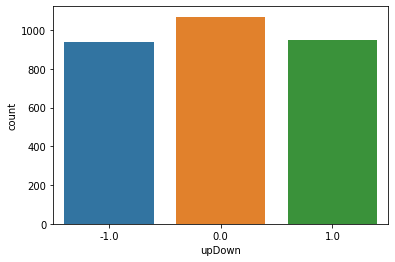

In [25]:
sns.countplot(df_2['upDown'])

In [35]:
df_graph = df_2[['Tweet']]

df_graph['Tweet Length'] = df_2['Tweet Length']

df_graph['Sentiment'] = df_2['Sentiment']

df_graph['target'] = target

df_graph.head()

,Tweet,Tweet Length,Sentiment,target
0,Please ignore prior tweets as that was someone...,106,0,1.0
1,Went to Iceland on Sat to ride bumper cars on ...,129,1,-1.0
2,I made the volume on the Model S,125,0,-1.0
3,Great Voltaire quote arguably better than Twai...,145,1,-1.0
4,That was a total non sequitur btw,42,0,-1.0


In [36]:
df_graph['Tweet Length'].describe()

count    12206.000000
mean       122.561117
std         81.676819
min          9.000000
25%         63.000000
50%        100.000000
75%        158.000000
max        851.000000
Name: Tweet Length, dtype: float64

<AxesSubplot:>

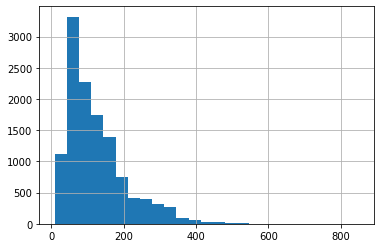

In [37]:
df_graph['Tweet Length'].hist(bins = 25)

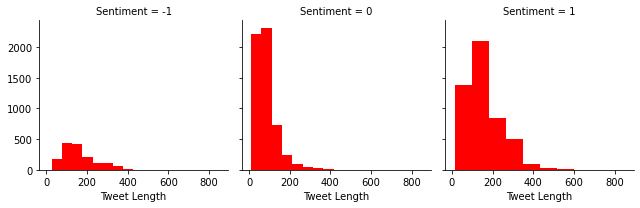

In [38]:
sentiment_graph = sns.FacetGrid(df_graph, col='Sentiment')
sentiment_graph.map(plt.hist, 'Tweet Length', color = 'r')

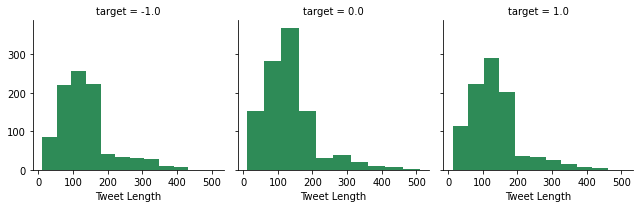

In [41]:
target_graph = sns.FacetGrid(df_graph,col='target')
target_graph.map(plt.hist,'Tweet Length', color='seagreen')

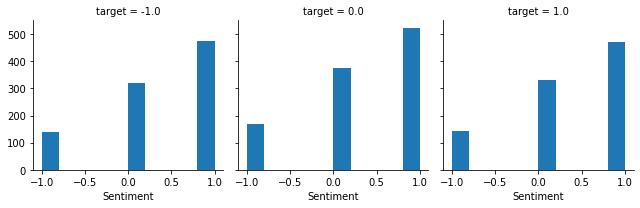

In [42]:
target_sentiment_graph = sns.FacetGrid(df_graph,col='target')
target_sentiment_graph.map(plt.hist,'Sentiment')

In [43]:
y = pd.get_dummies(target).values

In [44]:
print(type(y))
y[:4]

<class 'numpy.ndarray'>


array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [66]:
df_no_tweet = df_2.drop(['upDown', 'Tweet', 'Date','Retweets'], axis=1)

In [67]:
X = df_no_tweet.drop(columns=['Sentiment']).values

In [68]:
X[0].shape

(6554,)

In [69]:
X.shape

(12206, 6554)

In [70]:
print(type(y))

<class 'numpy.ndarray'>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train=np.asarray(X_train).astype(np.int)

y_train=np.asarray(y_train).astype(np.int)

In [54]:
classifier = Sequential()
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'tanh'))
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'tanh'))
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
c = classifier.fit(X_train, y_train, batch_size = 10, epochs = 4, validation_split=0.1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
score_no_tweet, acc_no_tweet = classifier.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score for the test data no tweet model: %.3f" % (score_no_tweet))
print("acc for the test data  no tweet model: %.7f" % (acc_no_tweet))

score_train_no_tweet, acc_train_no_tweet = classifier.evaluate(X_train, y_train, verbose = 2, batch_size = 32)
print("score for the training data no tweet model: %.3f" % (score_train_no_tweet))
print("acc for the training data no tweet model: %.7f" % (acc_train_no_tweet))